<a href="https://colab.research.google.com/github/promitee/Soft_computing/blob/main/170104154_exp_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Locate Dataset Path & Add Library

In [ ]:
from google.colab import drive
drive.mount('/Soft_Computing_Dataset')

Mounted at /Soft_Computing_Dataset


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader  
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
%cd /Soft_Computing_Dataset/MyDrive/Soft_Computing_Lab/Dataset_2
!unzip \*.zip

/Soft_Computing_Dataset/MyDrive/Soft_Computing_Lab/Dataset_2
Archive:  Dataset_2.zip
   creating: Dataset_2/
  inflating: Dataset_2/t10k-images-idx3-ubyte  
  inflating: Dataset_2/t10k-labels-idx1-ubyte  
  inflating: Dataset_2/train-images-idx3-ubyte  
  inflating: Dataset_2/train-labels-idx1-ubyte  
  inflating: Dataset_2/verification_test.csv  
  inflating: Dataset_2/verification_train.csv  


# Dataset

In [ ]:
train  = pd.read_csv('/Soft_Computing_Dataset/MyDrive/Soft_Computing_Lab/Dataset_2/Dataset_2/verification_train.csv')
test = pd.read_csv('/Soft_Computing_Dataset/MyDrive/Soft_Computing_Lab/Dataset_2/Dataset_2/verification_test.csv')

In [ ]:
class assignment_dataset_2(Dataset):
    def __init__(self, data, transform = None):
        self.data = list(data.values)
        self.transform = transform
        
        y_label = []
        image = []
        
        for i in self.data:
            y_label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(y_label)
        self.images = np.asarray(image).reshape(-1, 28, 28, 1)
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        y_label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [ ]:
train_set = assignment_dataset_2(train, transform=transforms.Compose([transforms.ToTensor()]))
test_set = assignment_dataset_2(test, transform=transforms.Compose([transforms.ToTensor()]))

# Hyperparameter & Dataset splitting

In [ ]:
batch_size = 200
num_iters = 20000
input_dim = 28 * 28 
num_hidden = 500
output_dim = 10
learning_rate = 0.1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=batch_size, 
                                           shuffle=True) 

test_loader = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=batch_size, 
                                          shuffle=False)  

num_epochs = num_iters / (len(train_set) / batch_size)
num_epochs = int(num_epochs)
print('Epoch Number: ',num_epochs)
print('Train set: ',len(train_set))
print('Train set: ',len(test_set))
print('Train dataloader: ',len(train_loader))
print('Train dataloader: ',len(test_loader))

Epoch Number:  66
Train set:  60000
Train set:  10000
Train dataloader:  300
Train dataloader:  50


In [ ]:
itr_loss = []
acc = []
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.tanh_1 = nn.Tanh()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.tanh_1(out)

        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iter = 0
for epoch in range(num_epochs):
  try:
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            itr_loss.append(loss.item())
            acc.append(accuracy)
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
  except Exception as e:
    print(e)

Iteration: 500. Loss: 0.5043308734893799. Accuracy: 82.83
Iteration: 1000. Loss: 0.48022568225860596. Accuracy: 83.19
Iteration: 1500. Loss: 0.42333632707595825. Accuracy: 83.3
Iteration: 2000. Loss: 0.38432231545448303. Accuracy: 83.37
Iteration: 2500. Loss: 0.4122728109359741. Accuracy: 85.21
Iteration: 3000. Loss: 0.3523421883583069. Accuracy: 83.83
Iteration: 3500. Loss: 0.6050381064414978. Accuracy: 79.17
Iteration: 4000. Loss: 0.4399062991142273. Accuracy: 84.1
Iteration: 4500. Loss: 0.4778766632080078. Accuracy: 84.88
Iteration: 5000. Loss: 0.41372260451316833. Accuracy: 85.38
Iteration: 5500. Loss: 0.5021746158599854. Accuracy: 82.43
Iteration: 6000. Loss: 0.391724169254303. Accuracy: 83.39
Iteration: 6500. Loss: 0.36602357029914856. Accuracy: 83.7
Iteration: 7000. Loss: 0.43175750970840454. Accuracy: 77.01
Iteration: 7500. Loss: 0.5424678921699524. Accuracy: 80.11
Iteration: 8000. Loss: 0.37542399764060974. Accuracy: 82.29
Iteration: 8500. Loss: 0.4783751666545868. Accuracy: 8

# Save Model

In [ ]:
torch.save(model.state_dict(), '/Soft_Computing_Dataset/MyDrive/Soft_Computing_Lab/Dataset_2/model_base_1.pkl')

# Visualize Model Result

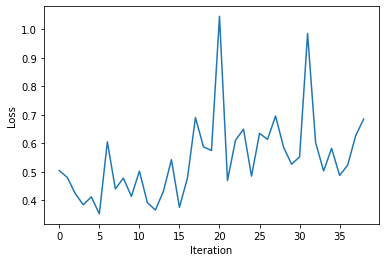

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(itr_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()
plt.savefig('/Soft_Computing_Dataset/MyDrive/Soft_Computing_Lab/Dataset_2/loss_exp_03.png')

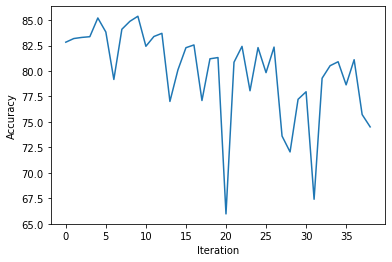

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(acc)
plt.ylabel('Accuracy')
plt.xlabel('Iteration')
plt.show()
plt.savefig('/Soft_Computing_Dataset/MyDrive/Soft_Computing_Lab/Dataset_2/acc_exp_03.png')